# Monoids

This notebook is to reproduce the work in the article "Monoids: Theme and Variations".

In [20]:
using Pkg
Pkg.activate("..")
using GeometryBasics
using PlotlyJS

  Activating project at `~/MEGA/EMAP/Diagrams.jl`
┌ Info: Precompiling PlotlyJS [f0f68f2c-4968-5e81-91da-67840de0976a]
└ @ Base loading.jl:1664


WebIO._IJuliaInit()

## 1. What is a Diagram?

The first question is how de we define a "Diagram". A simple description
is that a diagram is an *ordered collection of primitives*.

A primitive is any thing that we know how to draw. For example, if we are using SVG,
then our primitives includes things like lines, rectangles, circles ,ellipses, Bézier curves, and so on.

The order of the primitive defines which one is in top of the other.
We can note that a list with a concatenation operation creates a *monoid*. Hence,
we can say that a Diagram as such is a monoid.

## 2. A Diagram is a Monoid

A monoid is a category composed of a single object (type), a neutral element and an operator, e.g. $(M,e,\otimes)$.
In programming, $M$ is a type, $\otimes$ is a function with two arguments of type $M$, and $e$ is a value of type $M$;

Thus, consider $M$ to be the set of ordered list of primitives of type `Primitive`.
For two diagrams $D_1 = [p^{(1)}_1,...,p^{(1)}_n]$ and
$D_2 = [p^{(2)}_1,...,p^{(2)}_m]$, we have

$$
D_1 \otimes D_2 = 
[p^{(1)}_1,...,p^{(1)}_n,p^{(2)}_1,...,p^{(2)}_m].
$$

Note that the empty list `[]` is the null element. We can also show that this composition operation is associative.
Thus, the ordered list of primitives with concatenation operator does indeed defines a **monoid**.

Let's code this.

In [21]:
abstract type Primitive1 end

struct Circle1 <: Primitive1
    ρ::Real
    c::Vector
end

struct Square1 <: Primitive1
    l::Real
end

struct Point1 <: Primitive1
    p::Vector
end

struct Diagram1
    p::Vector{Primitive1}
end
Diagram1(p::Primitive1=[]) = Diagram1([p])

neutral(::Type{Diagram1}) = []

⋄(p::Vector{Primitive1}, q::Vector{Primitive1}) = vcat(p,q)
⋄(d1::Diagram1, d2::Diagram1) = Diagram1(d1.p ⋄ d2.p)

⋄ (generic function with 3 methods)

In [22]:
circle = Circle1(1,[0,0])

D = Diagram1([circle])

D.p == (Diagram1() ⋄ D).p

true

Here are some functions that can help working with a diagram. 

In [23]:
unD(d::Diagram1) = d.p
prim(p::Primitive1) = Diagram1([p])

prim (generic function with 1 method)

There is a *practical* issue with our `Diagram1` definition. Note that
if the order to draw the primitive is "first element, draw first", then
`p1 ⋄ p2` first draws `p1` and then `p2` above it.
This is contrary to what we might want. It's more "natural" to think of adding drawings
to the top, instead of to the bottom.

In [24]:
struct DiagramDual
    p::Vector{Primitive1}
end
DiagramDual(p::Primitive1=[]) = DiagramDual([p])
neutral(::Type{DiagramDual}) = []
⋄(d1::DiagramDual, d2::DiagramDual) = DiagramDual(d2.p ⋄ d1.p)

⋄ (generic function with 3 methods)

In [25]:
circle = Circle1(1,[0,0])
square = Square1(1)
point = Point1([1,1])

D1 = DiagramDual(circle)
D2 = DiagramDual(square)
D3 = DiagramDual([point, point])

D1 ⋄ D2 ⋄ D3

DiagramDual(Primitive1[Point1([1, 1]), Point1([1, 1]), Square1(1), Circle1(1, [0, 0])])

Note that now that the order follows the "desired" drawing order. 

## 3. Envelopes

Our Diagram can compose primitives. But we want to be able to do more complicated drawings.
For example, we might want to "glue" two primitives side by side.
To be able to do this, we need to know how much one primitive should be translated until it
touched only the "border" of the other.

Thus, it would be necessary to be able to compute this distance for each primitive.
This is what the author of the paper has called an *envelope*.

The envelope is a functional defined for each primitive, with
$env: V_2 \to \mathbb R$ where $V_2$ is a 2D vector.
This means that, when we define a primitive, we must also define it's envelope funciton.

**Def.(Envelope)** Given a diagram $D$ and a direction $v$,
$$
env_D(v) := \sup_{u \in D}\frac{\langle u,v\rangle}{||v||^2}.
$$

We call $\sup_{u \in D}\langle u,v\rangle$ the *support* function.

The nice thing about the envelope functional is that the envelope of a diagram $D = [p_1,p_2,...,p_n]$
is just $\max\{env(p_1),...,env(p_n)\}$, i.e. once we know how to compute the envelope of the primitives,
the envelope for the diagram can easily be found.

Let's use the `GeometricBasics.jl` package to define our primimtives. This package
has some geometric objects implemented, and some useful functionalities.

In [163]:
support(t::AbstractGeometry,v::Vector) = mapreduce(p->dot(p,v),max,coordinates(t))
envelope(t::AbstractGeometry, v::Vector) = support(t,normalize(v))

envelope (generic function with 1 method)

In [176]:
a = Point(-1.5,-0.5)#+Point(10,10)
b = Point(0.5,1.5)
c = Point(1.0,-0.5)
v = [1,1]

t = Triangle(a,b,c)
l = Line(a,b)
r = Rect(0,0,2,2)

HyperRectangle{2, Int64}([0, 0], [2, 2])

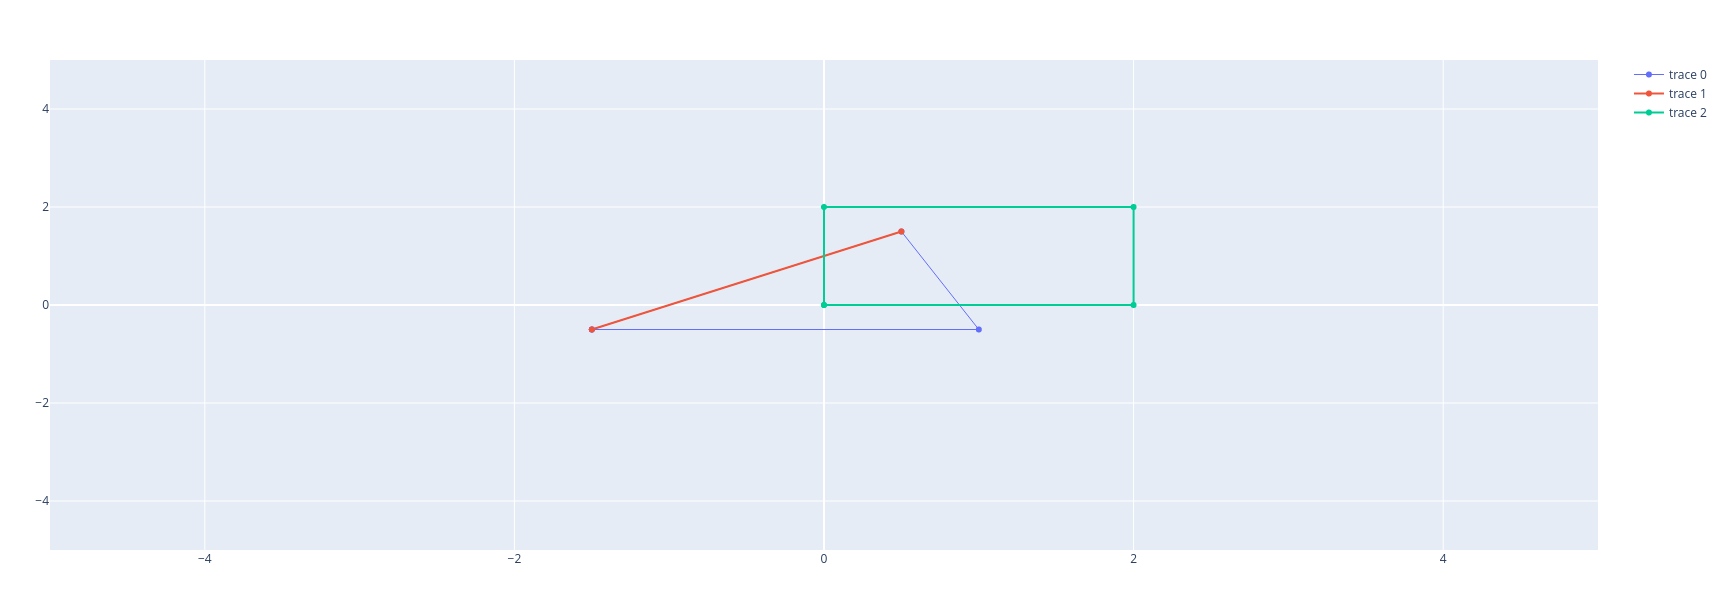

In [190]:
function plottriangle(t::Triangle; kwargs...)
    tp = vcat(vcat(t.points'...),t.points[1]')
    scatter(x = tp[:,1],y = tp[:,2]; kwargs...)
end

function plotline(t::Line; kwargs...)
    tp = vcat(t.points'...)
    scatter(x = tp[:,1],y = tp[:,2]; kwargs...)
end

function plotrectangle(r::Rect; kwargs...)
    tp = collect(coordinates(r))
    # adjusting order of points.
    tp = tp[[1,2,4,3]]
    tp = mapreduce(x->[x[1],x[2]]', vcat, tp)
    
    tp = vcat(tp, tp[1,:]')
    scatter(x = tp[:,1],y = tp[:,2]; kwargs...)
end

pt = plottriangle(t,line=attr(width=1))
pl = plotline(l)
pr = plotrectangle(r)



layout = Layout(
    xaxis = attr(range = [-5, 5]),
    yaxis = attr(range = [-5, 5]),
    width = 600,
    height = 600
)
plot([pt,pl, pr],layout)

scatter with fields type, x, and y


4×2 StaticArraysCore.SMatrix{4, 2, Float64, 8} with indices SOneTo(4)×SOneTo(2):
 -1.5  -0.5
  0.5   1.5
  1.0  -0.5
 -1.5  -0.5

In [ ]:
env(circle::Circle1) = circle.ρ
env(line::Line1) = circle.ρ